In [9]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
from PAC_Dataset import PACDataset, ConcatDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image
import torchvision.transforms.functional as TF

# Parser

In [2]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="400", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-3, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default="../train_related", help="save path")
parser.add_argument("--subfolder", type=str, default='test', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")
parser.add_argument("--epochs", type=int, default=2000, help="label shuffling")
parser.add_argument("--dann_weight", type=float, default=1, help="weight for label shuffling")
parser.add_argument("--start_shuffle_dann", type=int, default=100, help="when to start shuffling")
parser.add_argument("--is_shuffle", type=int, default=1, help="no shuffle if 0")


args = parser.parse_args()
# snap shot of py file and command
python_file_name = sys.argv[0]


usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE] [--learning_rate LEARNING_RATE] [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH] [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD] [--epochs EPOCHS] [--dann_weight DANN_WEIGHT]
                             [--start_shuffle_dann START_SHUFFLE_DANN] [--is_shuffle IS_SHUFFLE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/tianqinl/.local/share/jupyter/runtime/kernel-b8e64a17-b764-4f9f-8664-2fb96d3bff07.json


SystemExit: 2

/home/tianqinl/anaconda3/envs/pgm/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [4]:
# # local only
# class local_args:
#     def __init__(self, **entries):
#         self.__dict__.update(entries)
        
# args = local_args(**{
#     'batch_size': 200,
#     'learning_rate': 1e-3,
#     'momentum': 0.5,
#     'gpu_num': 0,
#     'seed': 123,
#     'save_path': "../train_related",
#     'epochs': 20,
#     'subfolder': "test",
#     'wtarget': 0.7,
#     'dann_weight': 1,
#     'model_save_period': 2,
#     'start_shuffle_dann': 1,
#     'is_shuffle': 0
# })

In [5]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)


model_sub_folder = args.subfolder + '/shuffle_weight_%f_learningrate_%f_startsepoch_%i_isshuffle_%i'%(args.dann_weight, args.learning_rate, args.start_shuffle_dann, args.is_shuffle)
save_folder = os.path.join(args.save_path, model_sub_folder)
if not os.path.exists(save_folder):
    os.makedirs(save_folder)   


cuda:0


In [6]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logfile_path = os.path.join(save_folder, 'logfile.log')
if os.path.isfile(logfile_path):
    os.remove(logfile_path)
    
file_log_handler = logging.FileHandler(logfile_path)
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)
logger.info("Fixed source testing bug")
attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)
logger.info("Training Save Path: {}".format(save_folder))


Fixed source testing bug
batch_size: 200
learning_rate: 0.001
momentum: 0.5
gpu_num: 0
seed: 123
save_path: ../train_related
epochs: 20
subfolder: test
wtarget: 0.7
dann_weight: 1
model_save_period: 2
start_shuffle_dann: 1
is_shuffle: 0
Training Save Path: ../train_related/test/shuffle_weight_1.000000_learningrate_0.001000_startsepoch_1_isshuffle_0


# Data loader

In [7]:
p_dataset_train = PACDataset('p', split = 'train')
p_dataset_test = PACDataset('p', split = 'test')
a_dataset_train = PACDataset('a', split = 'train')
a_dataset_test = PACDataset('a', split = 'test')
c_dataset_train = PACDataset('c', split = 'train')
c_dataset_test = PACDataset('c', split = 'test')
s_dataset_train = PACDataset('s', split = 'train')
s_dataset_test = PACDataset('s', split = 'test')

Loading photo train data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading photo test data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading art_painting train data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading art_painting test data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading cartoon train data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading cartoon test data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading sketch train data from /home/tianqinl/Code/PGM-project/data/pacs/cache
Loading sketch test data from /home/tianqinl/Code/PGM-project/data/pacs/cache


## Visual comfirm

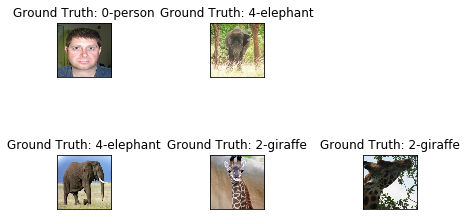

In [20]:
# p_dataloader = DataLoader(p_dataset_test, batch_size=args.batch_size, shuffle=True)
# # pacs
# examples = enumerate(p_dataloader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#     plt.subplot(2,3,i+1)
#     plt.tight_layout()
#     plt.imshow(example_data[i].permute(1, 2, 0))
#     plt.title("Ground Truth: {}-{}".format(example_targets[i], p_dataset_test.category_dict[int(example_targets[i])]))
#     plt.xticks([])
#     plt.yticks([])

In [8]:
p_train_dataloader = DataLoader(p_dataset_train, batch_size=args.batch_size, shuffle=True)
p_test_dataloader = DataLoader(p_dataset_test, batch_size=args.batch_size, shuffle=True)

a_train_dataloader = DataLoader(a_dataset_train, batch_size=args.batch_size, shuffle=True)
a_test_dataloader = DataLoader(a_dataset_test, batch_size=args.batch_size, shuffle=True)

c_train_dataloader = DataLoader(c_dataset_train, batch_size=args.batch_size, shuffle=True)
c_test_dataloader = DataLoader(c_dataset_test, batch_size=args.batch_size, shuffle=True)

s_train_dataloader = DataLoader(s_dataset_train, batch_size=args.batch_size, shuffle=True)
s_test_dataloader = DataLoader(s_dataset_test, batch_size=args.batch_size, shuffle=True)


# Shuffling label

In [16]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.randint(0,2,(mnist_trainset.data.shape[0],)), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.randint(0,2,(svhn_trainset.data.shape[0],)), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [10]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=10, padding=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=11, padding=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(55*55*20, 1024)
        self.fc2 = nn.Linear(1024, 300)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 6, stride=2, padding=2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 6, stride=2, padding=2))
        x = x.view(-1, 55*55*20)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x


In [11]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x
    
    def before_lastlinear(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        return x

        

In [12]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [13]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=300, d_h1=1000, d_h2=500, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=300, d_h1=1000, d_h2=500, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=300, out_features=1000, bias=True)
  (ln1): LayerNorm((1000,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (ln2): LayerNorm((500,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=500, out_features=2, bias=True)
)

# Train

In [27]:
target_acc_label_ = []
source_acc_1_ = []
source_acc_2_ = []
source_acc_3_ = []
source_test_acc_ = []
target_test_acc_ = []
domain_acc_ = []


loss_source_1_[]
loss_source_2_[]
loss_source_3_[]

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source 1 domain p
    CNet.train()
    encoder.train()
    source_acc_1 = 0.0
    num_datas = 0.0
    loss_source_1 = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(p_train_dataloader), total=len(p_train_dataloader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc_1 += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss_source_1 += loss.item
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc_1 = source_acc_1 / num_datas
    source_acc_1_.append(source_acc_1)
    loss_source_1_.append(loss_source_1)
    
    
    # on source 2 domain c
    CNet.train()
    encoder.train()
    source_acc_2 = 0.0
    num_datas = 0.0
    loss_source_2 = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(c_train_dataloader), total=len(c_train_dataloader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc_2 += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss_source_2 += loss.item()
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc_2 = source_acc_2 / num_datas
    source_acc_2_.append(source_acc_2)
    loss_source_2_.append(loss_source_2)
    
#     # DANN shuffle
#     if args.is_shuffle != 0:
#         accumulate_loss = 0.0
#         domain_acc = 0.0
#         DomainCNet.train()
#         encoder.train()
#         num_datas = 0.0
#         for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
#             optimizerCNet.zero_grad()
#             optimizerEncoder.zero_grad()
#             adv_x = adv_x.to(device).float()
#             adv_y = adv_y.to(device)
#             num_datas += adv_x.size(0)
#             adv_x_embedding = encoder(adv_x)
#             pred = DomainCNet(adv_x_embedding)
#             domain_acc += (pred.argmax(-1) == adv_y).sum().item()
#             # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
#             loss = args.dann_weight * criterion_classifier(pred, adv_y)
#             accumulate_loss += loss.item()
#             loss.backward()
            
#             optimizerDomainCNet.step()
#             if epoch >= args.start_shuffle_dann:
#                 optimizerEncoder.step()    
#         domain_acc = domain_acc / num_datas
#         domain_acc_.append(domain_acc)
#         if epoch == args.start_shuffle_dann:
#             logger.info("Start update Encoder using shuffling loss!")
#         logger.info("Epoch {}: Shuffling loss {}; ".format(epoch, accumulate_loss))
            
        

    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in tqdm(enumerate(p_test_dataloader), total=len(p_test_dataloader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in tqdm(enumerate(a_test_dataloader), total=len(a_test_dataloader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(target_test_acc)
    
    if epoch % args.model_save_period == 0:
        torch.save(DomainCNet.state_dict(), os.path.join(save_folder, 'DomainCNet_%i.t7'%(epoch+1)))
        torch.save(encoder.state_dict(), os.path.join(save_folder, 'encoder_%i.t7'%(epoch+1)))
        torch.save(CNet.state_dict(), os.path.join(save_folder, 'CNet_%i.t7'%(epoch+1)))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; domain acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, 10, target_test_acc))
    np.save(os.path.join(args.save_path, model_sub_folder, 'source_acc_.npy'),source_acc_)
    #np.save(os.path.join(args.save_path, model_sub_folder, 'source_test_acc_.npy'),source_test_acc_)
    np.save(os.path.join(args.save_path, model_sub_folder, 'target_test_acc_.npy'),target_test_acc_)
    #np.save(os.path.join(args.save_path, model_sub_folder, 'domain_acc_.npy'),domain_acc_)


Started Training
Started Training


100%|██████████| 4/4 [00:00<00:00, 10.33it/s]

Epochs 1: source train acc: 0.164243; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 1: source train acc: 0.164243; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.16it/s]

Epochs 2: source train acc: 0.213003; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 2: source train acc: 0.213003; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

Epochs 3: source train acc: 0.226689; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 3: source train acc: 0.226689; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.42it/s]

Epochs 4: source train acc: 0.212147; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 4: source train acc: 0.212147; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00,  9.59it/s]

Epochs 5: source train acc: 0.207870; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 5: source train acc: 0.207870; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.47it/s]

Epochs 6: source train acc: 0.206159; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 6: source train acc: 0.206159; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.54it/s]

Epochs 7: source train acc: 0.234388; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 7: source train acc: 0.234388; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.67it/s]

Epochs 8: source train acc: 0.251497; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 8: source train acc: 0.251497; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00,  9.73it/s]

Epochs 9: source train acc: 0.218991; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 9: source train acc: 0.218991; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00, 10.04it/s]

Epochs 10: source train acc: 0.229256; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878
Epochs 10: source train acc: 0.229256; source test acc: 0.229541; domain acc: 10.000000; target test acc: 0.204878



100%|██████████| 4/4 [00:00<00:00,  9.43it/s]

Epochs 11: source train acc: 0.247220; source test acc: 0.235529; domain acc: 10.000000; target test acc: 0.203252
Epochs 11: source train acc: 0.247220; source test acc: 0.235529; domain acc: 10.000000; target test acc: 0.203252



100%|██████████| 4/4 [00:00<00:00,  8.91it/s]

Epochs 12: source train acc: 0.265184; source test acc: 0.295409; domain acc: 10.000000; target test acc: 0.201626
Epochs 12: source train acc: 0.265184; source test acc: 0.295409; domain acc: 10.000000; target test acc: 0.201626



100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

Epochs 13: source train acc: 0.285714; source test acc: 0.379242; domain acc: 10.000000; target test acc: 0.221138
Epochs 13: source train acc: 0.285714; source test acc: 0.379242; domain acc: 10.000000; target test acc: 0.221138



100%|██████████| 4/4 [00:00<00:00,  9.81it/s]

Epochs 14: source train acc: 0.325920; source test acc: 0.375250; domain acc: 10.000000; target test acc: 0.221138
Epochs 14: source train acc: 0.325920; source test acc: 0.375250; domain acc: 10.000000; target test acc: 0.221138



100%|██████████| 4/4 [00:00<00:00, 10.01it/s]

Epochs 15: source train acc: 0.347305; source test acc: 0.379242; domain acc: 10.000000; target test acc: 0.230894
Epochs 15: source train acc: 0.347305; source test acc: 0.379242; domain acc: 10.000000; target test acc: 0.230894



100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

Epochs 16: source train acc: 0.351583; source test acc: 0.381238; domain acc: 10.000000; target test acc: 0.230894
Epochs 16: source train acc: 0.351583; source test acc: 0.381238; domain acc: 10.000000; target test acc: 0.230894



100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

Epochs 17: source train acc: 0.378101; source test acc: 0.389222; domain acc: 10.000000; target test acc: 0.222764
Epochs 17: source train acc: 0.378101; source test acc: 0.389222; domain acc: 10.000000; target test acc: 0.222764



100%|██████████| 4/4 [00:00<00:00, 10.49it/s]

Epochs 18: source train acc: 0.394354; source test acc: 0.385230; domain acc: 10.000000; target test acc: 0.227642
Epochs 18: source train acc: 0.394354; source test acc: 0.385230; domain acc: 10.000000; target test acc: 0.227642



100%|██████████| 4/4 [00:00<00:00, 10.31it/s]

Epochs 19: source train acc: 0.396920; source test acc: 0.421158; domain acc: 10.000000; target test acc: 0.195122
Epochs 19: source train acc: 0.396920; source test acc: 0.421158; domain acc: 10.000000; target test acc: 0.195122



100%|██████████| 4/4 [00:00<00:00, 10.68it/s]

Epochs 20: source train acc: 0.408896; source test acc: 0.429142; domain acc: 10.000000; target test acc: 0.175610
Epochs 20: source train acc: 0.408896; source test acc: 0.429142; domain acc: 10.000000; target test acc: 0.175610
